# Qualitative results

### Imports

In [1]:
import pandas as pd
import numpy as np
from glob import glob
from IPython.display import HTML, display, Markdown
import seaborn as sns
import matplotlib.pyplot as plt
# from data_mani.visu import *
from prediction.functions import aggregate_prediction_results, gen_strat_positions_and_ret_from_pred, ann_avg_returns_tb, ann_vol_tb, max_drawdown_tb, sharpe_ratio_tb, calmar_ratio_tb, plot_cum_ret
from time import time
init = time()

plt.style.use('bmh')

### Variables

In [2]:
models = ['logit', 'ridge', 'lasso', 'enet', 'random_forest', 'lgb', 'nn3'] + ['average', 'median', 'nncomb']
models2 = ['LOGIT', 'RIDGE', 'LASSO', 'ENET', 'RF', 'GB', 'NN3'] + ['AVERAGE', 'MEDIAN', 'NNCOMB']
fs_methods = ['all', 'sfi', 'mdi', 'mda', 'granger', 'huang', 'IAMB', 'MMMB']
fs_methods2 = ['ALL', 'SFI', 'MDI', 'MDA', 'GRANGER', 'HUANG', 'IAMB', 'MMMB']
tickers = ['SPX Index', 'CCMP Index','RTY Index', 'SPX Basic Materials',
           'SPX Communications', 'SPX Consumer Cyclical',
           'SPX Consumer Non cyclical', 'SPX Energy', 'SPX Financial',
           'SPX Industrial', 'SPX Technology', 'SPX Utilities']
benchmark_name = 'return_direction'
metric = "auc"
oos_start_date = '2012-07-03'
oos_end_date = '2020-12-31'
tickers_to_analyze = ['SPX Index', 'CCMP Index', 'RTY Index']

tickers_tags = {'SPX Index': 'S&P 500', 'CCMP Index': 'Nasdaq', 'RTY Index': 'Russell 2000'}

# Main reference

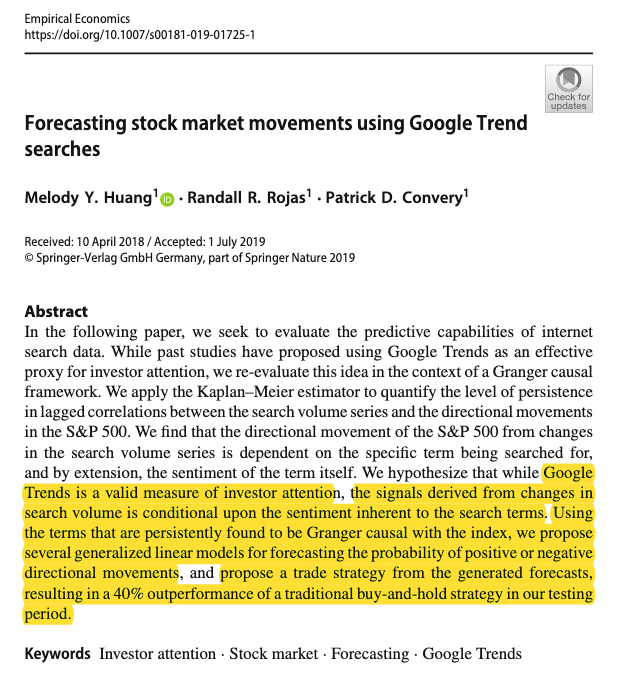

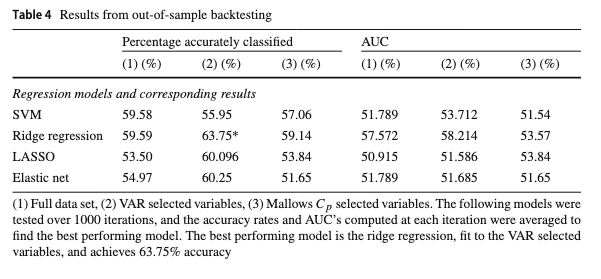

# Our models


## Feature Selection

> 1. All

> 2. Mean decrease impurity (random forest based) - MDI

> 3. Mean decrease accuracy (oos loss of performance; class based) - MDA

> 4. Single feature importance (oos individual feature; reg based) - SFI

> 5. Grenger causality - GRANGER

> 6. Granger causality + Logit - HUANG

> 7. Incremental association Markov boundary - IAMB

> 8. Max-Min Markov boundary - MMMB


## Prediction Models

> 1. Logit

> 2. Ridge regression

> 3. Lasso regression

> 4. Elastic net regression

> 5. Random Forest

> 6. Gradient Boosting

> 7. LSTM neural network (three layer)

## Prediction Setup

> 0. Sample from '2004-01-01' to '2020-12-31'

> 1. Feature selection: '2004-01-01' to '2012-07-03'

> 2. Forecasting: '2012-07-04' to '2020-12-31'

>> a. Random Search

>> b. Predict next year

>> c. Increase sample

# Aggregate prediction results

In [3]:
benchmarks = glob('data/indices/*.csv')
bench_list = []
for b in benchmarks:
    ticker = b.replace('data/indices/', '').replace('.csv', '')
    bench_ret_df = pd.read_csv(b)[3:]
    bench_ret_df.columns = ['date', 'return']
    bench_ret_df = bench_ret_df.melt('date')
    bench_ret_df['model'] = bench_ret_df['ticker'] = ticker
    bench_ret_df['fs'] = 'raw'

    bench_list.append(bench_ret_df)
benchmark_df = pd.concat(bench_list, axis=0)
benchmark_df['value'] = benchmark_df['value'].astype(float)

In [4]:
oos_melt_predictions_df, oos_melt_benchmark_df, oos_melt_auc_df = aggregate_prediction_results(prediction_models=models,
                                                                                               fs_models=fs_methods,
                                                                                               evaluation_start_date=oos_start_date,
                                                                                               evaluation_end_date=oos_end_date,
                                                                                               ticker_names=tickers,
                                                                                               metric_name=metric,
                                                                                               tag='oos',
                                                                                               benchmark_name=benchmark_name)

FileNotFoundError: [Errno 2] No such file or directory: 'results/forecast/all/indices/average/SPX Index.csv'

In [5]:
is_melt_predictions_df, is_melt_benchmark_df, is_melt_auc_df = aggregate_prediction_results(prediction_models=models,
                                                                                            fs_models=fs_methods,
                                                                                            evaluation_start_date='2005-01-03',
                                                                                            evaluation_end_date='2012-07-03',
                                                                                            ticker_names=tickers,
                                                                                            metric_name=metric,
                                                                                            tag='is',
                                                                                            benchmark_name=benchmark_name)

FileNotFoundError: [Errno 2] No such file or directory: 'results/forecast/all/indices/average/SPX Index.csv'

## 1) AUC Analysis

In [ ]:
is_auc_df = is_melt_auc_df.pivot_table(index=['fs'], columns=['model'], values=['isauc'], aggfunc='median')
simple_cols = [c[1] for c in is_auc_df.columns]
is_auc_df.columns = simple_cols
is_auc_df = is_auc_df.loc[fs_methods2][models2].apply(lambda x: np.round(x,3))

display(Markdown("### 1.1) In sample AUC median values"))
display(HTML(is_auc_df.to_html()))
sns.heatmap(is_auc_df);

In [ ]:
print((is_auc_df * 100).reset_index().to_latex(index=False))

In [ ]:
oos_auc_df = oos_melt_auc_df.pivot_table(index=['fs'], columns=['model'], values=['oosauc'], aggfunc='median')
simple_cols = [c[1] for c in oos_auc_df.columns]
oos_auc_df.columns = simple_cols
oos_auc_df = oos_auc_df.loc[fs_methods2][models2].apply(lambda x: np.round(x,3))

display(Markdown("### 1.2) Out of sample AUC median values"))
display(HTML(oos_auc_df.to_html()))
sns.heatmap(oos_auc_df);

In [ ]:
print((oos_auc_df * 100).reset_index().to_latex(index=False))

In [ ]:
display(Markdown("### 1.3) Out of sample AUC distribution across forecasting models"))

fig, ax = plt.subplots(figsize=(22,10))
sns.boxplot(x="model", y='oosauc',data=oos_melt_auc_df, ax=ax, order=models2, color='lightblue');
ax.set_ylabel("AUC", fontsize=30);
ax.set_xlabel("Model", fontsize=30);
ax.axhline(y=0.50, color='k', linestyle='--', alpha=0.5, label="random guess");
ax.tick_params(axis="x", labelsize=20);
ax.tick_params(axis="y", labelsize=20);
ax.legend(loc="best",fontsize=15);
fig.savefig('img/oos_auc_models_distr.png')

In [ ]:
display(Markdown("### 1.4) Out of sample AUC distribution across feature selection methods"))

fig, ax = plt.subplots(figsize=(22,10))
sns.boxplot(x="fs", y='oosauc',data=oos_melt_auc_df, ax=ax, order=fs_methods2, color='lightblue');
ax.set_ylabel("AUC", fontsize=30);
ax.set_xlabel("Feature selection method", fontsize=30);
ax.axhline(y=0.50, color='k', linestyle='--', alpha=0.5, label="random guess");
ax.tick_params(axis="x", labelsize=20);
ax.tick_params(axis="y", labelsize=20);
ax.legend(loc="best",fontsize=15);
fig.savefig('img/oos_auc_fs_methods_distr.png')

In [ ]:
tickers_to_analyze

In [ ]:
for ts in tickers_to_analyze:
    oos_spx_auc_df = oos_melt_auc_df[oos_melt_auc_df["ticker"] == ts].reset_index(drop=True)

    oos_spx_auc_df1 = oos_spx_auc_df.copy()
    oos_spx_auc_df1 = oos_spx_auc_df.pivot_table(index=['fs'], columns=['model'], values=['oosauc'], aggfunc='median')
    simple_cols = [c[1] for c in oos_spx_auc_df1.columns]
    oos_spx_auc_df1.columns = simple_cols
    oos_spx_auc_df1 = oos_spx_auc_df1.loc[fs_methods2][models2].apply(lambda x: np.round(x,3))

    display(Markdown("### 1.2) Out of sample AUC median values (" + ts + " only)"))
    display(HTML(oos_spx_auc_df1.to_html()))
    sns.heatmap(oos_spx_auc_df1);
    plt.show()
    
    print((oos_spx_auc_df1 * 100).reset_index().to_latex(index=False))

    display(Markdown("### 1.5) Out of sample AUC distribution across forecasting models (" + ts + " only)"))

    fig, ax = plt.subplots(figsize=(22,10))
    sns.boxplot(x="model", y='oosauc',
                data=oos_spx_auc_df, ax=ax, order=models2, color='lightblue');
    sns.swarmplot(x="model", y='oosauc',
                  data=oos_spx_auc_df,ax=ax,
                  color="k",order=models2)

    ax.set_ylabel("AUC", fontsize=30);
    ax.set_xlabel("Model", fontsize=30);
    ax.axhline(y=0.50, color='k', linestyle='--', alpha=0.5, label="random guess");
    ax.tick_params(axis="x", labelsize=20);
    ax.tick_params(axis="y", labelsize=20);
    ax.legend(loc="best",fontsize=15);
    plt.show()
    fig.savefig("img/oos_auc_models_distr_" + ts.split(" ")[0].lower() + ".png")

    display(Markdown("### 1.6) Out of sample AUC distribution across feature selection methods (" + ts + " only)"))

    fig, ax = plt.subplots(figsize=(22,10))
    sns.boxplot(x="fs", y='oosauc',data=oos_spx_auc_df, ax=ax, order=fs_methods2, color='lightblue');
    sns.swarmplot(x="fs", y='oosauc',
                  data=oos_spx_auc_df,ax=ax,
                  color="k",order=fs_methods2)
    ax.set_ylabel("AUC", fontsize=30);
    ax.set_xlabel("Feature selection method", fontsize=30);
    ax.axhline(y=0.50, color='k', linestyle='--', alpha=0.5, label="random guess");
    ax.tick_params(axis="x", labelsize=20);
    ax.tick_params(axis="y", labelsize=20);
    ax.legend(loc="best",fontsize=15);
    plt.show()
    fig.savefig("img/oos_auc_fs_methods_distr_" + ts.split(" ")[0].lower() + ".png")

    display(Markdown("### 1.5) Out of sample AUC distribution across forecasting models (" + ts + " only)"))

    fig, ax = plt.subplots(figsize=(22,10))
    sns.boxplot(x="model", y='oosauc',
                data=oos_spx_auc_df, ax=ax, order=models2, color='lightblue');
    sns.swarmplot(x="model", y='oosauc',
                  data=oos_spx_auc_df,ax=ax,
                  color="k",order=models2)

    ax.set_ylabel("AUC", fontsize=30);
    ax.set_xlabel("Model", fontsize=30);
    ax.axhline(y=0.50, color='k', linestyle='--', alpha=0.5, label="random guess");
    ax.tick_params(axis="x", labelsize=20);
    ax.tick_params(axis="y", labelsize=20);
    ax.legend(loc="best",fontsize=15);
    plt.show()
    fig.savefig("img/oos_auc_models_distr_" + ts.split(" ")[0].lower() + ".png")


In [ ]:
oos_pred_ret_df, oos_pred_pos_df = gen_strat_positions_and_ret_from_pred(predictions_df=oos_melt_predictions_df,
                                                                         class_threshold=0.5,
                                                                         target_asset_returns=benchmark_df)

ret_all_df = pd.concat([oos_pred_ret_df, benchmark_df], axis=0)

oos_benchmark_df = benchmark_df.loc[(benchmark_df['date'])>= oos_start_date]
pivot_oos_benchmark_df = oos_benchmark_df.pivot_table(index=['date'], columns=['model'], values=['value']).dropna()
pivot_oos_benchmark_df.columns = pivot_oos_benchmark_df.columns.droplevel()
pivot_oos_benchmark_df['Combined portfolio'] = pivot_oos_benchmark_df.mean(axis=1)

ann_avg_ret_benchmark = (pivot_oos_benchmark_df.mean() * 252).reset_index()
ann_avg_ret_benchmark.columns = ['ticker', 'Ann. Avg. Return']
# ann_avg_ret = ann_avg_ret_benchmark.loc[ann_avg_ret_benchmark['ticker'] == 'Combined portfolio']['Ann Avg Return'].iloc[0]

ann_vol_benchmark = (pivot_oos_benchmark_df.std() * np.sqrt(252)).reset_index()
ann_vol_benchmark.columns = ['ticker', 'Ann. Volatility']
# ann_vol_ret = ann_vol_benchmark.loc[ann_vol_benchmark['ticker'] == 'Combined portfolio']['Ann Volatility'].iloc[0]

sr_benchmark = (pivot_oos_benchmark_df.mean() / pivot_oos_benchmark_df.std() * np.sqrt(252)).reset_index()
sr_benchmark.columns = ['ticker', 'Sharpe ratio']
# average_sr = sr_benchmark.loc[sr_benchmark['ticker'] == 'Combined portfolio']['sharpe ratio'].iloc[0]

cum_prod_df = (1 + pivot_oos_benchmark_df / 100).cumprod()
previous_peaks_df = cum_prod_df.cummax()
mdd_benchmark = (cum_prod_df - previous_peaks_df) / previous_peaks_df
mdd_benchmark = pd.DataFrame(mdd_benchmark.min().sort_values(ascending=False) * 100).reset_index()
mdd_benchmark.columns = ['ticker', 'Max. drawdown']
# average_mdd = mdd_df.loc[mdd_df['ticker'] == 'Combined portfolio']['max drawdown'].iloc[0]

ann_avg_ret_benchmark.set_index('ticker', inplace=True)
mdd_benchmark.set_index('ticker', inplace=True)
cr_benchmark = pd.merge(ann_avg_ret_benchmark, mdd_benchmark, right_index=True, left_index=True)
cr_benchmark['Calmar ratio'] = (ann_avg_ret_benchmark['Ann. Avg. Return'] / 100) / ((mdd_benchmark['Max. drawdown'] * -1) / 100)
cr_benchmark = cr_benchmark[['Calmar ratio']]
cr_benchmark = cr_benchmark.reset_index()

In [ ]:
ts = "Combined portfolio"

display(Markdown("## 1) Sharpe ratio - " + ts))
average_sr = sr_benchmark.loc[sr_benchmark['ticker'] == ts]['Sharpe ratio'].iloc[0]
sr_rank_df, sr_tb_df, sr_agg_df = sharpe_ratio_tb(returns_df=ret_all_df.dropna(),
                                                  level_to_subset='fs',
                                                  rf=.0)
sr_df = sr_rank_df.reset_index()
sr_df_raw = sr_df.loc[sr_df["fs"]=="raw"].reset_index(drop=True)
sr_df = sr_df.loc[sr_df["fs"]!="raw"].reset_index(drop=True)
sr_df_spx = sr_df.loc[sr_df["ticker"]==ts].reset_index(drop=True)

# Sanity Check
assert oos_melt_auc_df.shape[0] == sr_df.shape[0]

simple_sr_df = sr_df.pivot_table(index=['fs'], columns=['model'], values=['Sharpe ratio'], aggfunc='median')
simple_cols = [c[1] for c in simple_sr_df.columns]
simple_sr_df.columns = simple_cols
simple_sr_df = simple_sr_df.loc[fs_methods2][models2].apply(lambda x: np.round(x,3))

display(Markdown("### 1.1) Out of sample Ann. Sharpe ratio median values (" + ts + " average benchmark {:.3f})".format(average_sr)))
display(HTML(simple_sr_df.to_html()))
sns.heatmap(simple_sr_df);
plt.show()
print((simple_sr_df.apply(lambda x: np.round(x,2))).reset_index().to_latex(index=False))

display(Markdown("### 1.2) Out of sample Ann. Sharpe ratio distribution across forecasting models (" + ts + " only)"))
fig, ax = plt.subplots(figsize=(22,10))
sns.boxplot(x="model", y='Sharpe ratio', data=sr_df, ax=ax, order=models2, color='lightblue');
ax.set_ylabel("Sharpe ratio", fontsize=30);
ax.set_xlabel("Model", fontsize=30);
ax.axhline(y=average_sr, color='k', linestyle='--', alpha=0.5, label="buy-and-hold benchmark");
ax.tick_params(axis="x", labelsize=20);
ax.tick_params(axis="y", labelsize=20);
ax.legend(loc="best",fontsize=15);
plt.show()
fig.savefig("img/oos_sr_models_distr_" + ts.split(" ")[0].lower() + ".png")

display(Markdown("### 1.3) Out of sample Ann. Sharpe ratio distribution across feature selection methods (" + ts + " only)"))
fig, ax = plt.subplots(figsize=(22,10))
sns.boxplot(x="fs", y='Sharpe ratio',data=sr_df, ax=ax, order=fs_methods2, color='lightblue');
ax.set_ylabel("Sharpe ratio", fontsize=30);
ax.set_xlabel("Feature selection method", fontsize=30);
ax.axhline(y=average_sr, color='k', linestyle='--', alpha=0.5, label="buy-and-hold benchmark");
ax.tick_params(axis="x", labelsize=20);
ax.tick_params(axis="y", labelsize=20);
ax.legend(loc="best",fontsize=15);
plt.show()
fig.savefig("img/oos_sr_fs_methods_distr_" + ts.split(" ")[0].lower() + ".png")

display(Markdown("## 2) Calmar ratio - " + ts))
average_cr = cr_benchmark.loc[cr_benchmark['ticker'] == ts]['Calmar ratio'].iloc[0]
cr_rank_df, cr_tb_df, cr_agg_df = calmar_ratio_tb(returns_df=ret_all_df.dropna(),
                                                  level_to_subset='fs')
cr_df = cr_rank_df.reset_index()
cr_df_raw = cr_df.loc[cr_df["fs"]=="raw"].reset_index(drop=True)
cr_df = cr_df.loc[cr_df["fs"]!="raw"].reset_index(drop=True)
cr_df_spx = cr_df.loc[cr_df["ticker"]==ts].reset_index(drop=True)

# Sanity Check
assert oos_melt_auc_df.shape[0] == cr_df.shape[0]

simple_cr_df = cr_df.pivot_table(index=['fs'], columns=['model'], values=['Calmar ratio'], aggfunc='median')
simple_cols = [c[1] for c in simple_cr_df.columns]
simple_cr_df.columns = simple_cols
simple_cr_df = simple_cr_df.loc[fs_methods2][models2].apply(lambda x: np.round(x,3))

display(Markdown("### 2.1) Out of sample Ann. Calmar ratio median values (" + ts + " average benchmark {:.3f})".format(average_cr)))
display(HTML(simple_cr_df.to_html()))
sns.heatmap(simple_cr_df);
plt.show()
print((simple_cr_df.apply(lambda x: np.round(x,2))).reset_index().to_latex(index=False))

display(Markdown("### 2.2) Out of sample Ann. Calmar ratio distribution across forecasting models (" + ts + " only)"))
fig, ax = plt.subplots(figsize=(22,10))
sns.boxplot(x="model", y='Calmar ratio', data=cr_df, ax=ax, order=models2, color='lightblue');
ax.set_ylabel("Calmar ratio", fontsize=30);
ax.set_xlabel("Model", fontsize=30);
ax.axhline(y=average_cr, color='k', linestyle='--', alpha=0.5, label="buy-and-hold benchmark");
ax.tick_params(axis="x", labelsize=20);
ax.tick_params(axis="y", labelsize=20);
ax.legend(loc="best",fontsize=15);
plt.show()
fig.savefig("img/oos_cr_models_distr_" + ts.split(" ")[0].lower() + ".png")

display(Markdown("### 2.3) Out of sample Ann. Calmar ratio distribution across feature selection methods (" + ts + " only)"))
fig, ax = plt.subplots(figsize=(22,10))
sns.boxplot(x="fs", y='Calmar ratio',data=cr_df, ax=ax, order=fs_methods2, color='lightblue');
ax.set_ylabel("Calmar ratio", fontsize=30);
ax.set_xlabel("Feature selection method", fontsize=30);
ax.axhline(y=average_cr, color='k', linestyle='--', alpha=0.5, label="buy-and-hold benchmark");
ax.tick_params(axis="x", labelsize=20);
ax.tick_params(axis="y", labelsize=20);
ax.legend(loc="best",fontsize=15);
plt.show()
fig.savefig("img/oos_cr_fs_methods_distr_" + ts.split(" ")[0].lower() + ".png")

In [ ]:
for ts in tickers_to_analyze:
    # subset returns
    tmp_ret_all_df = ret_all_df.loc[ret_all_df['ticker'] == ts].dropna()
    
    display(Markdown("## 1) Sharpe ratio - " + ts))
    average_sr = sr_benchmark.loc[sr_benchmark['ticker'] == ts]['Sharpe ratio'].iloc[0]
    sr_rank_df, sr_tb_df, sr_agg_df = sharpe_ratio_tb(returns_df=tmp_ret_all_df,
                                                      level_to_subset='fs',
                                                      rf=.0)
    sr_df = sr_rank_df.reset_index()
    sr_df_raw = sr_df.loc[sr_df["fs"]=="raw"].reset_index(drop=True)
    sr_df = sr_df.loc[sr_df["fs"]!="raw"].reset_index(drop=True)
    sr_df_spx = sr_df.loc[sr_df["ticker"]==ts].reset_index(drop=True)

    # Sanity Check
    assert oos_melt_auc_df.loc[oos_melt_auc_df['ticker'] == ts].shape[0] == sr_df.shape[0]

    simple_sr_df = sr_df.pivot_table(index=['fs'], columns=['model'], values=['Sharpe ratio'], aggfunc='median')
    simple_cols = [c[1] for c in simple_sr_df.columns]
    simple_sr_df.columns = simple_cols
    simple_sr_df = simple_sr_df.loc[fs_methods2][models2].apply(lambda x: np.round(x,3))

    display(Markdown("### 1.1) Out of sample Ann. Sharpe ratio median values (" + ts + " average benchmark {:.3f})".format(average_sr)))
    display(HTML(simple_sr_df.to_html()))
    sns.heatmap(simple_sr_df);
    plt.show()
    print((simple_sr_df.apply(lambda x: np.round(x,2))).reset_index().to_latex(index=False))

    display(Markdown("### 1.2) Out of sample Ann. Sharpe ratio distribution across forecasting models (" + ts + " only)"))
    fig, ax = plt.subplots(figsize=(22,10))
    sns.boxplot(x="model", y='Sharpe ratio', data=sr_df, ax=ax, order=models2, color='lightblue');
    ax.set_ylabel("Sharpe ratio", fontsize=30);
    ax.set_xlabel("Model", fontsize=30);
    ax.axhline(y=average_sr, color='k', linestyle='--', alpha=0.5, label="buy-and-hold benchmark");
    ax.tick_params(axis="x", labelsize=20);
    ax.tick_params(axis="y", labelsize=20);
    ax.legend(loc="best",fontsize=15);
    plt.show()
    fig.savefig("img/oos_sr_models_distr_" + ts.split(" ")[0].lower() + ".png")

    display(Markdown("### 1.3) Out of sample Ann. Sharpe ratio distribution across feature selection methods (" + ts + " only)"))
    fig, ax = plt.subplots(figsize=(22,10))
    sns.boxplot(x="fs", y='Sharpe ratio',data=sr_df, ax=ax, order=fs_methods2, color='lightblue');
    ax.set_ylabel("Sharpe ratio", fontsize=30);
    ax.set_xlabel("Feature selection method", fontsize=30);
    ax.axhline(y=average_sr, color='k', linestyle='--', alpha=0.5, label="buy-and-hold benchmark");
    ax.tick_params(axis="x", labelsize=20);
    ax.tick_params(axis="y", labelsize=20);
    ax.legend(loc="best",fontsize=15);
    plt.show()
    fig.savefig("img/oos_sr_fs_methods_distr_" + ts.split(" ")[0].lower() + ".png")
    
    display(Markdown("## 2) Calmar ratio - " + ts))
    average_cr = cr_benchmark.loc[cr_benchmark['ticker'] == ts]['Calmar ratio'].iloc[0]
    cr_rank_df, cr_tb_df, cr_agg_df = calmar_ratio_tb(returns_df=tmp_ret_all_df,
                                                      level_to_subset='fs')
    cr_df = cr_rank_df.reset_index()
    cr_df_raw = cr_df.loc[cr_df["fs"]=="raw"].reset_index(drop=True)
    cr_df = cr_df.loc[cr_df["fs"]!="raw"].reset_index(drop=True)
    cr_df_spx = cr_df.loc[cr_df["ticker"]==ts].reset_index(drop=True)

    # Sanity Check
    assert oos_melt_auc_df.loc[oos_melt_auc_df['ticker'] == ts].shape[0] == cr_df.shape[0]

    simple_cr_df = cr_df.pivot_table(index=['fs'], columns=['model'], values=['Calmar ratio'], aggfunc='median')
    simple_cols = [c[1] for c in simple_cr_df.columns]
    simple_cr_df.columns = simple_cols
    simple_cr_df = simple_cr_df.loc[fs_methods2][models2].apply(lambda x: np.round(x,3))

    display(Markdown("### 2.1) Out of sample Ann. Calmar ratio median values (" + ts + " average benchmark {:.3f})".format(average_cr)))
    display(HTML(simple_cr_df.to_html()))
    sns.heatmap(simple_cr_df);
    plt.show()
    print((simple_cr_df.apply(lambda x: np.round(x,2))).reset_index().to_latex(index=False))

    display(Markdown("### 2.2) Out of sample Ann. Calmar ratio distribution across forecasting models (" + ts + " only)"))
    fig, ax = plt.subplots(figsize=(22,10))
    sns.boxplot(x="model", y='Calmar ratio', data=cr_df, ax=ax, order=models2, color='lightblue');
    ax.set_ylabel("Calmar ratio", fontsize=30);
    ax.set_xlabel("Model", fontsize=30);
    ax.axhline(y=average_cr, color='k', linestyle='--', alpha=0.5, label="buy-and-hold benchmark");
    ax.tick_params(axis="x", labelsize=20);
    ax.tick_params(axis="y", labelsize=20);
    ax.legend(loc="best",fontsize=15);
    plt.show()
    fig.savefig("img/oos_cr_models_distr_" + ts.split(" ")[0].lower() + ".png")

    display(Markdown("### 2.3) Out of sample Ann. Calmar ratio distribution across feature selection methods (" + ts + " only)"))
    fig, ax = plt.subplots(figsize=(22,10))
    sns.boxplot(x="fs", y='Calmar ratio',data=cr_df, ax=ax, order=fs_methods2, color='lightblue');
    ax.set_ylabel("Calmar ratio", fontsize=30);
    ax.set_xlabel("Feature selection method", fontsize=30);
    ax.axhline(y=average_cr, color='k', linestyle='--', alpha=0.5, label="buy-and-hold benchmark");
    ax.tick_params(axis="x", labelsize=20);
    ax.tick_params(axis="y", labelsize=20);
    ax.legend(loc="best",fontsize=15);
    plt.show()
    fig.savefig("img/oos_cr_fs_methods_distr_" + ts.split(" ")[0].lower() + ".png")

## 3) Cummulative returns

In [ ]:
for idx, ticker in enumerate(tickers_to_analyze):
    display(Markdown("## " + str(idx+1) + ") Cummulative returns - " + ticker))
    
    summary_oos_pred_ret_df = oos_pred_ret_df.loc[oos_pred_ret_df['ticker']==ticker]
    summary_benchmark_df = benchmark_df.loc[benchmark_df['ticker']==ticker]

    for key1 in summary_oos_pred_ret_df['fs'].unique():
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_title(label='OOS ' + tickers_tags[ticker] + ' cummulative returns for each forecast model, given feature selection method ' + key1, fontsize=15)

        for key2 in summary_oos_pred_ret_df['model'].unique():
            loop_df = summary_oos_pred_ret_df.loc[(summary_oos_pred_ret_df['fs'] == key1)&
                                                  (summary_oos_pred_ret_df['model'] == key2)&
                                                  (summary_oos_pred_ret_df['ticker'] == ticker)]
            ax.plot(pd.to_datetime(loop_df['date']), (1+loop_df['value']/100).cumprod(), label=key2)

        bench = summary_benchmark_df.loc[(summary_benchmark_df['ticker']==ticker)&(summary_benchmark_df['date'] >= loop_df['date'].iloc[0])]
        ax.plot(pd.to_datetime(bench['date']), (1+bench['value']/100).cumprod(), label='buy n hold ' + ticker, color='black', linewidth=2)

        plt.xlabel("Date")
        plt.ylabel("Cummulative returns of 1$ invested on the beginning of the sample")
        plt.legend(loc='best', fontsize=10)   
        fig.savefig('img/' + ticker + '_' + key1 + '_fs_methods.png')
        plt.show()

## 4) Simulation comparison between the Sharpe ratio and the AUC

In [ ]:
spx_df = benchmark_df.loc[benchmark_df['ticker']=='SPX Index']
oos_spx_df = spx_df.loc[spx_df['date']>=oos_start_date]
pivot_oos_spx_df = oos_spx_df.pivot_table(index=['date'], columns=['ticker'], values=['value'])
pivot_oos_spx_df.columns = pivot_oos_spx_df.columns.droplevel()

In [ ]:
simu_num = 100
ps = [0.5, 0.51, 0.52, 0.53, 0.54, 0.55]

true_class_df = pivot_oos_spx_df.copy()
true_class_df.loc[true_class_df[true_class_df.columns[0]] > 0] = 1
true_class_df.loc[true_class_df[true_class_df.columns[0]] < 0] = -1

for p in ps:
    out_simu_list = []
    n = int(np.round(true_class_df.shape[0] * p))

    for i in range(0, simu_num+1):
        name = 'random' + str(i)
        sample_true_class_df = true_class_df.sample(n=n, replace=False)
        sample_true_class_df.rename(columns={sample_true_class_df.columns[0]: name}, inplace=True)
        simu_df = pd.concat([true_class_df, sample_true_class_df], axis=1)
        simu_df.loc[(pd.isna(simu_df[simu_df.columns[1]]))&(simu_df[simu_df.columns[0]] > 0), name] = -1
        simu_df.loc[(pd.isna(simu_df[simu_df.columns[1]]))&(simu_df[simu_df.columns[0]] < 0), name] = 1
        simu_df = simu_df[[name]]
        
        spx_simu_df = pd.DataFrame(simu_df.values * pivot_oos_spx_df.values,
                                  columns=['spx_random_pred' + str(i)])
        out_simu_list.append(spx_simu_df)
    out_simu_df = pd.concat(out_simu_list, axis=1)
    out_simu_df.index = pivot_oos_spx_df.index

    out_simu_df = pd.concat([out_simu_df, pivot_oos_spx_df], axis=1)
    out_simu_df = out_simu_df.reset_index()

    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title('Cummulative returns for the S&P 500 index with known hit rate of ' + str(p*100) + '%',
                fontsize=15)

    for key in out_simu_df.columns:
        if key == 'date':
            continue

        if key == 'SPX Index':
            ax.plot(pd.to_datetime(out_simu_df['date']),
                    (1 + out_simu_df[key]/100).cumprod(),
                    color='blue')
        else:
             ax.plot(pd.to_datetime(out_simu_df['date']),
                    (1 + out_simu_df[key]/100).cumprod(),
                    color='black',
                    alpha=0.5)
    plt.xlabel("Date")
    plt.ylabel("Cummulative returns of 1$ invested on the beginning of the sample")
    plt.legend(loc='best', fontsize=10)    
    fig.savefig('img/' + 'known_hitrate' + str(np.round(p)) + '_spx_simulation.png')
plt.show()

In [ ]:
simu_num = 1000
ps = [0.5, 0.51, 0.52, 0.53, 0.54, 0.55]

true_class_df = pivot_oos_spx_df.copy()
true_class_df.loc[true_class_df[true_class_df.columns[0]] > 0] = 1
true_class_df.loc[true_class_df[true_class_df.columns[0]] < 0] = -1

out_list = []
for p in ps:
    out_simu_list = []
    n = int(np.round(true_class_df.shape[0] * p))

    for i in range(0, simu_num+1):
        name = 'random' + str(i)
        sample_true_class_df = true_class_df.sample(n=n, replace=False)
        sample_true_class_df.rename(columns={sample_true_class_df.columns[0]: name}, inplace=True)
        simu_df = pd.concat([true_class_df, sample_true_class_df], axis=1)
        simu_df.loc[(pd.isna(simu_df[simu_df.columns[1]]))&(simu_df[simu_df.columns[0]] > 0), name] = -1
        simu_df.loc[(pd.isna(simu_df[simu_df.columns[1]]))&(simu_df[simu_df.columns[0]] < 0), name] = 1
        simu_df = simu_df[[name]]
        
        spx_simu_df = pd.DataFrame(simu_df.values * pivot_oos_spx_df.values,
                                  columns=['spx_random_pred' + str(i)])
        out_simu_list.append(spx_simu_df)
    out_simu_df = pd.concat(out_simu_list, axis=1)
    out_simu_df.index = pivot_oos_spx_df.index
    
    hist_simu = out_simu_df.mean() / out_simu_df.std() * np.sqrt(252)
    hist_simu = hist_simu.reset_index()
    hist_simu.rename(columns={hist_simu.columns[1]: 'value'}, inplace=True)
    hist_simu['auc'] = str(p)
    
    out_list.append(hist_simu)
out_simu_df = pd.concat(out_list, axis=0)
out_simu_df.rename(columns={'value': 'sharpe ratio'}, inplace=True)

In [ ]:
display(Markdown("### 1.3) Sharpe ratio distirbution for simulated strategies with fixed AUC"))

fig, ax = plt.subplots(figsize=(22,10))
sns.boxplot(x="auc", y='sharpe ratio',data=out_simu_df, ax=ax, color='lightblue');
ax.set_ylabel("Sharpe ratio", fontsize=30);
ax.set_xlabel("AUC", fontsize=30);
ax.axhline(y=0.86, color='k', linestyle='--', alpha=0.5, label="buy-and-hold SPX Index");
ax.tick_params(axis="x", labelsize=20);
ax.tick_params(axis="y", labelsize=20);
ax.legend(loc="best",fontsize=15);
fig.savefig('img/boxplot_simu_sr_known_auc.png')

In [ ]:
tot_time = time() - init
tot_time = tot_time / 60
print("notebook time = {:.3f} (minutes)".format(tot_time))